**Please visit https://ProStepSky.github.io/.**

This work © 2024 by "ProStepSky.github.io จัดทำโดย S.U." is licensed under [CC BY-NC-ND 4.0](http://creativecommons.org/licenses/by-nc-nd/4.0/)  
(อ้างอิงแหล่งที่มา ห้ามนำไปใช้เพื่อการค้า และห้ามดัดแปลง)

---

# Import Libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Suppress all warnings 
import warnings
warnings.filterwarnings("ignore")

# Import Data

Import การกู้ยืมที่มีสถานะเป็นหนี้สูญ (written-off) ซึ่งได้จากการคัดเลือกเมื่อ notebook ชื่อ 07 - LGD and EAD - Preparing the Data:

In [3]:
loan_data_defaults = pd.read_csv('./data/loan_data_defaults.csv')

# Explore Dependent Variables

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Set the default style of the graphs to the seaborn style. 

วาดกราฟ histogram ของตัวแปรตาม recovery rate (ร้อยละความเสียหายที่กู้คืนได้) โดยใช้ 50 bins:

(array([2.1023e+04, 1.8370e+03, 3.8730e+03, 1.3940e+03, 2.1330e+03,
        3.3440e+03, 4.7650e+03, 1.7130e+03, 1.1790e+03, 4.0600e+02,
        3.4100e+02, 2.7400e+02, 1.1700e+02, 9.3000e+01, 8.1000e+01,
        7.3000e+01, 5.4000e+01, 7.2000e+01, 5.7000e+01, 3.0000e+01,
        4.7000e+01, 2.7000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.1000e+01, 9.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.3000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

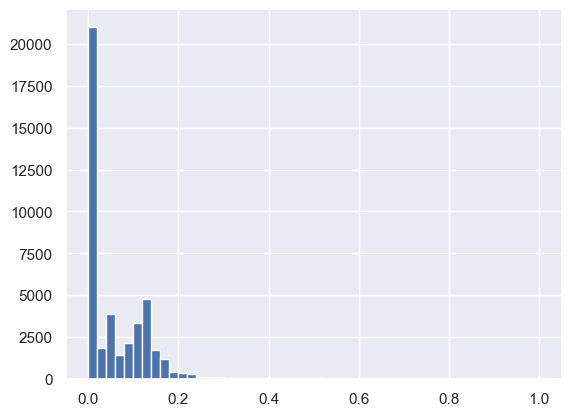

In [5]:
plt.hist(loan_data_defaults['recovery_rate'], bins = 50)

จากกราฟ histogram ข้างบนพบว่า ประมาณครึ่งหนึ่งของผู้ขอกู้มี recovery rate (ร้อยละความเสียหายที่กู้คืนได้) เท่ากับ 0

ดังนั้น การทำนาย Loss Given Default (LGD: เปอร์เซนต์ความเสียหายเมื่อลูกหนี้ผิดนัดชำระหนี้) จึงสมเหตุสมผลที่จะแยกการทำนายเป็นสองขั้นตอน (Two-stage approach) ในขั้นตอนถัดไป

ตัวแปร recovery rate มีค่าเป็นอัตราส่วนคือมีค่าอยู่ระหว่าง 0 ถึง 1 ซึ่งหากอธิบายความหนาแน่นของอัตราส่วน (density of proportion) ด้วยการแจกแจงแบบ beta distribution จะดีที่สุด โดย beta regression จะนำมาใช้สร้างโมเดลที่มีผลลัพธ์ระหว่าง 0 ถึง 1

แต่ขณะนี้ยังไม่มี python library หลัก ๆ ที่รองรับ beta regression ดังนั้น จึงจะแยกการทำนายเป็นสองขั้นตอน (Two-stage approach) ดังนี้

- <font color='darkorange'>**Stage 1: logistic regression**</font> เพื่อหา recovery rate ว่ามีค่าเท่ากับ 0 หรือมากกว่า 0?
    - ถ้า recovery rate มีค่าเท่ากับ 0 นั่นคือ มีค่าเท่ากับ 0 ไม่ต้องทำนายต่อแล้ว
    - ถ้า recovery rate มีค่ามากกว่า 0 จะใช้ <font color='darkorange'>**Stage 2: linear regression**</font> เพื่อทำนายต่อไปว่า recovery rate นั้น มีค่าเท่ากับเท่าไร?

จากกราฟการแจกแจงของตัวแปร recovery rate ข้างบนพบว่า ประมาณครึ่งหนึ่งของผู้ขอกู้มี recovery rate เท่ากับ 0 ในขณะที่อีกประมาณครึ่งหนึ่งมี recovery rate มากกว่า 0

ดังนั้น การทำนาย Loss Given Default (LGD: เปอร์เซนต์ความเสียหายเมื่อลูกหนี้ผิดนัดชำระหนี้) จึงจะแยกการทำนายเป็นสองขั้นตอน (Two-stage approach):

1. Recovery rate (ร้อยละความเสียหายที่กู้คืนได้) มีค่าเท่ากับ 0 หรือมากกว่า 0?
2. ถ้า recovery rate มีค่ามากกว่า 0 แล้ว recovery rate นั้น มีค่าเท่ากับเท่าไร?

---
---
---

# ➡ <font color='dodgerblue'><u>LGD Model</u></font> ⬅

## <font color='darkorange'>*Stage 1: Logistic Regression*</font>

ถ้า recovery_rate เท่ากับ 0 แล้ว, ให้ recovery_rate_0_1 มีค่าเท่ากับ 0

ถ้า recovery_rate ไม่เท่ากับ 0 (คือมากกว่า 0) แล้ว, ให้ recovery_rate_0_1 มีค่าเท่ากับ 1

ดำเนินการดังนี้:

In [6]:
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)

In [7]:
loan_data_defaults['recovery_rate_0_1']

0        1
1        1
2        1
3        1
4        1
        ..
43231    0
43232    0
43233    1
43234    0
43235    0
Name: recovery_rate_0_1, Length: 43236, dtype: int32

การกู้ยืมที่มีสถานะเป็นหนี้สูญ (written-off) ที่มีค่า recovery rate มากกว่า 0 จะถูกนำไปใช้ใน Stage 2: linear regression เพื่อทำนายต่อไปว่า recovery rate นั้น มีค่าเท่ากับเท่าไร

### Splitting Data

ทำ train/test split ด้วยอัตราส่วน 80:20

In [8]:
from sklearn.model_selection import train_test_split

ใช้ input เป็น การกู้ยืมที่มีสถานะเป็นหนี้สูญ (written-off) ที่มีสถานะเป็นหนี้สูญ (written-off) แต่ drop ตัวแปรตาม good_bad, recovery_rate, recovery_rate_0_1, CCF

ใช้ target เป็น recovery_rate_0_1

ดังนี้:

In [9]:
lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['recovery_rate_0_1'], test_size = 0.2, random_state = 42)

### Preparing the Inputs

สร้างตัวแปร features_all เพื่อเก็บเฉพาะชื่อของตัวแปรอิสระที่ต้องใช้เท่านั้น:

In [10]:
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

สร้างตัวแปร features_reference_cat เพื่อเก็บชื่อของ dummy variable reference categories:

In [11]:
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

เลือกเก็บเฉพาะตัวแปรที่ต้องใช้เท่านั้น นั่นคือตัวแปรที่มีชื่ออยู่ใน features_all list:

In [12]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]

ต้องทำการกำจัด 1 dummy variable สำหรับตัวแปรต้นฉบับแต่ละตัว เพื่อป้องกันปัญหา dummy variable trap ซึ่งทำให้เกิด multicollinearity

ทำการ drop ตัวแปรที่เป็น dummy variable reference categories:

In [13]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis = 1)

### Estimating the Model (LGD stage 1 model)

ดัดแปลง .fit() method จาก Logistic Regression class เพื่อให้คำนวณ p-values ได้:

In [14]:
# P values for sklearn logistic regression.

# Class to display p-values for logistic regression in sklearn.

from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    # Inherit everything from the original LogisticRegression class.
    def __init__(self,*args,**kwargs):#,**kwargs):

        # -------------------------------------------------------
        # This function will be provided upon request. Thank you.
        # -------------------------------------------------------

    # Overwrite .fit() with a function that calculate p-values.
    def fit(self,X,y):
        
        # -------------------------------------------------------
        # This function will be provided upon request. Thank you.
        # -------------------------------------------------------

สร้าง instance โดยใช้ class ที่ผ่านการดัดแปลงให้สามารถคำนวณ p-values ได้:

In [15]:
reg_lgd_st_1 = LogisticRegression_with_p_values()

ทำการ fit model:

In [16]:
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

แสดงจุดตัดแกน, สัมประสิทธิ์ของ, และ p-values สำหรับ LGD stage 1 model (Logistic Regression):

In [17]:
feature_name = lgd_inputs_stage_1_train.columns.values

In [18]:
# Column titled 'Feature name' with row values contained in the 'feature_name'.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)

# Column titled 'Coefficients'
# with row values the transposed coefficients from the 'LogisticRegression' object
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)

# +1 to the index of every row.
summary_table.index = summary_table.index + 1

# Assign values of the row with index 0.
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]

# Sort the DataFrame by index.
summary_table = summary_table.sort_index()

# Take the result of the newly added method 'p_values'.
p_values = reg_lgd_st_1.p_values

# Add the 'NaN' value at the beginning of the list,
# which is the same position as the intercept row.
p_values = np.append(np.nan,np.array(p_values))

# Add a new column to the table.
summary_table['p_values'] = p_values

In [19]:
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-4.053534e-04,NaN
1,grade:A,-6.164895e-05,9.994270e-01
2,grade:B,-2.687978e-04,9.969014e-01
3,grade:C,-4.215971e-04,9.949535e-01
4,grade:D,4.200980e-05,9.995166e-01
5,grade:E,4.860321e-05,9.994928e-01
6,grade:F,2.190215e-04,9.980109e-01
7,home_ownership:MORTGAGE,-9.481987e-05,9.970475e-01
8,home_ownership:NONE,2.520283e-06,9.999975e-01
9,home_ownership:OTHER,-2.069700e-07,9.999996e-01


จากตารางข้างบนพบว่า ค่า p-values ของตัวแปรจำนวนมาก ไม่ได้มีนัยสำคัญทางสถิติ หมายความว่า...

ตัวแปรที่ไม่ได้มีนัยสำคัญทางสถิติ ไม่ว่าจะตัดทิ้งไปหรือจะเก็บเอาไว้ ความสามารถในการทำนายของตัว LGD stage 1 model (Logistic Regression) ก็ยังคงเหมือนเดิมแทบจะไม่เปลี่ยนแปลง

ค่าสัมประสิทธิ์ของ LGD stage 1 model (Logistic Regression) หมายความว่าทุกหนึ่งหน่วยของตัวแปรที่เพิ่มขึ้นจะทำให้ค่า ln(odds) เปลี่ยนไปเท่ากับค่าสัมประสิทธิ์ของตัวแปรนั้น โดยแปรผลได้ดังนี้

>ยกตัวอย่าง: ถ้า purpose เป็น educational ค่า ln(odds) ของการกู้ยืมที่มี recovery rate มากกว่า 0 จะลดลง 1.727734e-06 หรือ 0.00000173

ค่าสัมประสิทธิ์ครั้งนี้ ต่างจากตอนทำ PD model คือมีตัวแปรประเภท continuous ด้วย ซึ่งตัวแปรประเภท continuous จะแปรผลได้ดังนี้

>ยกตัวอย่าง: ทุกหนึ่งหน่วยของ funded_amnt (จำนวนเงินที่ปล่อยกู้) ที่เพิ่มขึ้น ค่า ln(odds) ของการกู้ยืมที่มี recovery rate มากกว่า 0 จะเพิ่มขึ้น 4.549876e-05 หรือ 0.000045
>
>ยกตัวอย่าง: ทุกหนึ่งหน่วยของ dti (อัตราส่วนภาระหนี้ต่อเดือน หารรายได้ต่อเดือน) ที่เพิ่มขึ้น ค่า ln(odds) ของการกู้ยืมที่มี recovery rate มากกว่า 0 จะลดลง 1.521180e-02 หรือ 0.015

### Testing the Model (LGD stage 1 model)

เลือกเก็บเฉพาะตัวแปรที่ต้องการใช้เท่านั้น:

In [20]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]

ทำการ drop ตัวแปรที่เป็น dummy variable reference categories:

In [21]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1)

ทำการทำนายโดยใช้ LGD stage 1 model (Logistic Regression)

(ทำนายโดยใช้ default cut-off ที่ 50%; นั่นคือ <= 50% จะทำนายว่า recovery_rate เท่ากับ 0; หาก > 50% จะทำนายว่า recovery_rate มากกว่า 0):

In [22]:
y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test)

In [23]:
y_hat_test_lgd_stage_1

array([1, 1, 0, ..., 1, 1, 0])

ทำการทำนายโดยใช้ LGD stage 1 model (Logistic Regression)

(โดยจะไม่ทำนายเป็นผลลัพธ์ว่า recovery_rate เท่ากับ 0 หรือมากกว่า 0 แต่จะให้ผลลัพธ์คือความน่าจะเป็นดิบ หรือ raw probabilities):

In [24]:
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test)

In [25]:
y_hat_test_proba_lgd_stage_1

array([[0.41693255, 0.58306745],
       [0.3683145 , 0.6316855 ],
       [0.58433537, 0.41566463],
       ...,
       [0.47401823, 0.52598177],
       [0.41662074, 0.58337926],
       [0.55939917, 0.44060083]])

จาก array ข้างบน:

- column แรกคือ ความน่าจะเป็นที่ recovery_rate เท่ากับ 0
- column ที่สองคือ ความน่าจะเป็นที่ recovery_rate มากกว่า 0

เลือกเก็บเฉพาะ column ที่สอง (ความน่าจะเป็นที่ recovery_rate มากกว่า 0):

In [26]:
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[: ][: , 1]

In [27]:
y_hat_test_proba_lgd_stage_1

array([0.58306745, 0.6316855 , 0.41566463, ..., 0.52598177, 0.58337926,
       0.44060083])

ทำการรวมค่าจริง (lgd_targets_stage_1_test_temp) กับค่าทำนาย (y_hat_test_proba_lgd_stage_1) ไว้ใน DataFrame เดียวกัน สำหรับการประเมินความแม่นยำของ model:

In [28]:
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test

In [29]:
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace = True)

In [30]:
df_actual_predicted_probs = pd.concat([lgd_targets_stage_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)], axis = 1)

In [31]:
df_actual_predicted_probs.columns = ['lgd_targets_stage_1_test', 'y_hat_test_proba_lgd_stage_1']

In [32]:
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index

In [33]:
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
21362,1,0.583067
8768,1,0.631686
11903,0,0.415665
42973,1,0.553585
29933,0,0.422103


### Estimating the Аccuracy of the Мodel (LGD stage 1 model)

การประเมินความแม่นยำของ model

#### ทำนาย Probability of Default (PD) โดยใช้ threshold หรือ cut-off probability เท่ากับ 50%:

In [34]:
tr = 0.5
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > tr, 1, 0)

แสดง confusion matrix:

In [35]:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'],
            df_actual_predicted_probs['y_hat_test_lgd_stage_1'],
            rownames = ['Actual'],
            colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,1557,2205
1,1057,3829


จาก confusion matrix ข้างบน ที่ threshold เท่ากับ 50% พบว่า:
- มี 1557 การกู้ยืม ที่ทำนายถูก ว่า recovery_rate = 0
- มี 1057 การกู้ยืม ที่ทำนายผิด ว่า recovery_rate = 0
- มี 3829 การกู้ยืม ที่ทำนายถูก ว่า recovery_rate > 0
- มี 2205 การกู้ยืม ที่ทำนายผิด ว่า recovery_rate > 0

แสดง confusion matrix (แสดงเป็นสัดส่วนต่อผู้ขอกู้ทั้งหมด):

In [36]:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'],
            df_actual_predicted_probs['y_hat_test_lgd_stage_1'],
            rownames = ['Actual'],
            colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.180042,0.254972
1,0.122225,0.442761


จาก confusion matrix ด้านบนพบ false positive = 25.49% และ false negative = 12.22%

คำนวณค่า accuracy ของ model ตัวนี้ (สัดส่วนของจำนวนที่ทำนายถูกทั้งหมดต่อผู้ขอกู้ทั้งหมด):

In [37]:
# True Negative
tn = (pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'],
                  df_actual_predicted_probs['y_hat_test_lgd_stage_1'],
                  rownames = ['Actual'],
                  colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0]

# True Positive
tp = (pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'],
                  df_actual_predicted_probs['y_hat_test_lgd_stage_1'],
                  rownames = ['Actual'],
                  colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]

tn + tp

0.6228029602220166

จากข้างบนเป็นค่า accuracy ที่ threshold เท่ากับ 50% เท่านั้น

ถ้าวาดกราฟ Receiver Operating Characteristic (ROC) ทุกจุดบนเส้น curve คือแต่ละ threshold ดังนั้น กราฟ ROC จะให้ข้อมูลมากกว่าสำหรับการนำไปใช้ประเมินประสิทธิภาพของตัว model 

คำนวณ false positive rates, true positive rates, thresholds:

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score

In [39]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'],
                                 df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])

วาดกราฟ Receiver Operating Characteristic (ROC) curve:

Text(0.5, 1.0, 'ROC curve')

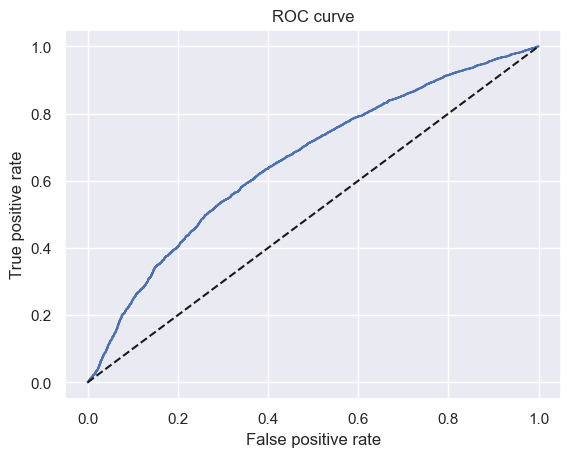

In [40]:
# Plot the ROC curve.
plt.plot(fpr, tpr)

# Plot a secondary diagonal dashed line.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

คำนวณ Area Under the Curve (AUC):

In [41]:
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
AUROC

0.6572667015285022

สำหรับเหตุการณ์ที่เกิดขึ้นอย่างบังเอิญ เช่น การโยนเหรียญมีโอกาสออกหัวก้อย 50/50 นั้น:
- Area Under the Curve (AUC) มีค่าเท่ากับ 50%

สำหรับ PD model นี้:
- Area Under the Curve (AUC) มีค่าเท่ากับ 65.73%
- AUC = 65.73% นี้ โดยทั่วไปถือว่าสามารถทำนายได้ดีปานกลาง

เนื่องจาก model นี้เป็น stage 1 เพื่อหาว่า recovery rate มีค่าเท่ากับ 0 หรือมากกว่า 0

ดังนั้น ใน stage 1 นี้ จึงควรทำให้จำนวนการกู้ยืมที่ "ทำนายถูกว่า recovery_rate > 0" มีมากกว่า "การทำนายถูกว่า recovery_rate = 0"

เพราะถึงแม้ว่าจะมีบางการกู้ยืมที่โดน "ทำนายผิดว่า recovery_rate > 0" หลุดไปยัง model ของ stage 2 ในขั้นตอนต่อไปได้ การกู้ยืมที่หลุดไปนี้ก็ยังคงมีโอกาสถูกทำนายใหม่อีกครั้งให้ถูกต้องว่ามีค่า = 0 ได้

### Saving the Model (LGD stage 1 model)

บันทึก LGD model (stage 1) ลง disk:

In [42]:
import pickle

In [43]:
filehandler = open('./data/lgd_model_stage_1.pkl','wb')
pickle.dump(reg_lgd_st_1,filehandler)
filehandler.close()

---

## <font color='darkorange'>*Stage 2: Linear Regression*</font>

Stage 2: linear regression จะทำนายเฉพาะการกู้ยืมที่มีค่า recovery rate มากกว่า 0 ว่า ค่า recovery rate นั้น มีค่าเท่ากับเท่าไร

เลือกเฉพาะการกู้ยืมที่ model ใน stage 1 ได้ทำนายไว้ว่ามีค่า recovery rate มากกว่า 0 (นั่นคือ recovery_rate_0_1 = 1):

In [44]:
lgd_stage_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]

ใช้ input เป็น lgd_stage_2_data แต่ drop ตัวแปรตาม good_bad, recovery_rate, recovery_rate_0_1, CCF

ใช้ target เป็น recovery_rate

ดังนี้:

In [45]:
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), lgd_stage_2_data['recovery_rate'], test_size = 0.2, random_state = 42)

In [46]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

ดัดแปลง .fit() method จาก Linear Regression class เพื่อให้คำนวณ p-values ได้:

In [47]:
# Since the p-values are obtained through certain statistics, we need the 'stat' module from scipy.stats
import scipy.stats as stat

# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):

        # -------------------------------------------------------
        # This function will be provided upon request. Thank you.
        # -------------------------------------------------------
        
    
    def fit(self, X, y, n_jobs=1):
        
        # -------------------------------------------------------
        # This function will be provided upon request. Thank you.
        # -------------------------------------------------------
        
        return self

เลือกเก็บเฉพาะตัวแปรที่ต้องการใช้เท่านั้น:

In [48]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]

ทำการ drop ตัวแปรที่เป็น dummy variable reference categories:

In [49]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)

สร้าง instance โดยใช้ class ที่ผ่านการดัดแปลงให้สามารถคำนวณ p-values ได้:

In [50]:
reg_lgd_st_2 = LinearRegression()

ทำการ fit model:

In [51]:
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)

LinearRegression()

แสดงจุดตัดแกน, สัมประสิทธิ์ของ, และ p-values สำหรับ LGD stage 2 model (Linear Regression):

In [52]:
feature_name = lgd_inputs_stage_2_train.columns.values

In [53]:
# Column titled 'Feature name' with row values contained in the 'feature_name'.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)

# Column titled 'Coefficients'
# with row values the transposed coefficients from the 'LinearRegression' object
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)

# +1 to the index of every row.
summary_table.index = summary_table.index + 1

# Assign values of the row with index 0.
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]

# Sort the DataFrame by index.
summary_table = summary_table.sort_index()

# Take the result of the newly added method 'p_values'.
p_values = reg_lgd_st_2.p

# Add the 'NaN' value at the beginning of the list,
# which is the same position as the intercept row.
p_values = np.append(np.nan,np.array(p_values))

# Add a new column to the table.
summary_table['p_values'] = p_values.round(3)

In [54]:
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.409222e-01,NaN
1,grade:A,-6.804653e-02,0.000
2,grade:B,-5.067942e-02,0.000
3,grade:C,-3.739224e-02,0.000
4,grade:D,-2.712438e-02,0.000
5,grade:E,-1.314241e-02,0.002
6,grade:F,-5.230491e-03,0.277
7,home_ownership:MORTGAGE,2.832918e-03,0.060
8,home_ownership:NONE,1.461056e-01,0.000
9,home_ownership:OTHER,-9.396799e-03,0.646


จากตารางข้างบนพบว่า ค่า p-values ของตัวแปรจำนวนมากใน LGD stage 2 model นี้ มีนัยสำคัญทางสถิติ ซึ่งต่างจากตอนทำ LGD stage 1 model

ค่าสัมประสิทธิ์ของ LGD stage 1 model (Logistic Regression) หมายความว่าทุกหนึ่งหน่วยของตัวแปรที่เพิ่มขึ้นจะทำให้ค่า ln(odds) เปลี่ยนไปเท่ากับค่าสัมประสิทธิ์ของตัวแปรนั้น

แต่ค่าสัมประสิทธิ์ของ LGD stage 2 model (Linear Regression) ครั้งนี้ หมายความว่าทุกหนึ่งหน่วยของตัวแปรที่เพิ่มขึ้น จะทำให้ค่า recovery rate เปลี่ยนไปเท่ากับค่าสัมประสิทธิ์ของตัวแปรนั้น ซึ่งแปรผลได้ดังนี้

>ยกตัวอย่าง: ถ้า purpose เป็น educational ค่า recovery rate จะเพิ่มขึ้น 7.616802e-02 หรือ 7.62%
>
>ยกตัวอย่าง: ทุกหนึ่งหน่วย (1 USD) ของ annual_inc (รายรับต่อปีของผู้ขอกู้) ที่เพิ่มขึ้น ค่า recovery rate จะเพิ่มขึ้น 6.359065e-08 หรือ 0.00000636%
>
>ยกตัวอย่าง: ทุกหนึ่งหน่วย (1%) ของ int_rate (อัตราดอกเบี้ย) ที่เพิ่มขึ้น ค่า recovery rate จะลดลง 2.539466e-03 หรือ 0.254%

### Testing the Model (LGD stage 2 model)

เลือกเก็บเฉพาะตัวแปรที่ต้องการใช้เท่านั้น:

In [55]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]

ทำการ drop ตัวแปรที่เป็น dummy variable reference categories:

In [56]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)

In [57]:
lgd_inputs_stage_2_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

ทำการทำนายค่า recovery rate กับการกู้ยืมที่มีค่า recovery rate มากกว่า 0 (lgd_inputs_stage_2_test):

In [58]:
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)

Reset index ของ DataFrame ของค่าจริง เพื่อให้ index ตรงกับ DataFrame ของค่าทำนาย:

In [59]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test

In [60]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test_temp.reset_index(drop = True)

ทำการประเมินประสิทธิภาพ model โดยหาค่าสหสัมพันธ์ (correlation) ระหว่างค่าจริง (lgd_targets_stage_2_test_temp) กับ ค่าทำนาย (y_hat_test_lgd_stage_2):

In [61]:
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()

,recovery_rate,0
recovery_rate,1.000000,0.309047
0,0.309047,1.000000


ค่าสหสัมพันธ์ (correlation) ระหว่างค่าจริงกับค่าทำนาย คือ 0.309047 ถือว่ามีสหสัมพันธ์เล็กน้อยถึงปานกลางซึ่งถือว่าน่าพอใจสำหรับ LDG model หากค่าสหสัมพันธ์สูงมากไป อาจหมายถึงมีขั้นตอนบางอย่างผิดปกติ

ทำการประเมินประสิทธิภาพ model โดยวาดกราฟแสดงการกระจายตัวของผลต่างระหว่างค่าจริง (lgd_targets_stage_2_test) กับ ค่าทำนาย (y_hat_test_lgd_stage_2):

<Axes: xlabel='recovery_rate', ylabel='Density'>

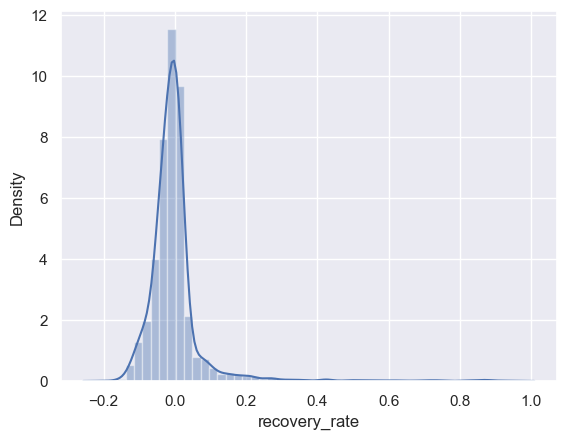

In [62]:
# Plot the distribution of the residuals.
sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)

จากกราฟข้างบนพบว่า การกระจายตัวของผลต่างระหว่างค่าจริงกับค่าทำนาย มีลักษณะเป็น normal distribution และผลต่างส่วนใหญ่มีการกระจายตัวค่อนข้างสมมาตร ณ บริเวณค่าเท่ากับ 0 และผลต่างส่วนใหญ่กระจุกอยู่ที่บริเวณค่าเท่ากับ 0 บ่งบอกว่า model นี้มีระเบียบวิธีที่ดี และมีความสามารถในการทำนายค่อนข้างดี

### Saving the Model (LGD stage 2 model)

บันทึก LGD model (stage 2) ลง disk:

In [63]:
filehandler = open('./data/lgd_model_stage_2.pkl','wb')
pickle.dump(reg_lgd_st_2,filehandler)
filehandler.close()

---

## <font color='darkorange'>*Combining Stage 1 and Stage 2*</font>

ทำการรวม LGD stage 1 model (Logistic Regression) กับ LGD stage 2 model (Linear Regression) เข้าด้วยกันเพื่อให้เป็น LGD model ตัวจริง

ตอน LGD stage 2 model จะทำนายเฉพาะการกู้ยืมที่มีค่า recovery rate มากกว่า 0 เท่านั้น

แต่ตอนนี้ จะทำการทำนายการกู้ยืมที่มีค่า recovery rate ทั้งเท่ากับ 0 และ มากกว่า 0 (นั่นคือ test input และ target จากการกู้ยืมทั้งหมด):

In [64]:
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)

ผลการทำนายโดยใช้ LGD stage 2 model (โดยไม่สนว่า LGD stage 1 model จะทำนายเป็นเท่ากับ 0 หรือมากกว่า 0 หรือไม่):

In [65]:
y_hat_test_lgd_stage_2_all

array([0.11902462, 0.09642583, 0.13368658, ..., 0.12050299, 0.11563043,
       0.15690616])

ทำการรวมผลการทำนาย (โดยการคูณ) ทั้ง stage 1 และ stage 2 เข้าด้วยกัน จะได้คำตอบสุดท้ายของผลทำนายค่า recovery rate:

In [66]:
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all

หาก LGD stage 1 model ทำนายว่า recovery rate = 0 จะได้ผลทำนายจาก stage 1 เป็น 0
- เมื่อคูณกับผลทำนายจาก stage 2 จะได้คำตอบสุดท้าย เป็น `0`

หาก LGD stage 1 model ทำนายว่า recovery rate > 0 จะได้ผลทำนายจาก stage 1 เป็น 1
- เมื่อคูณกับผลทำนายจาก stage 2 จะได้คำตอบสุดท้าย เป็น `ผลทำนายจาก stage 2`

แสดงสถิติของคำตอบสุดท้ายของผลทำนายค่า recovery rate:

In [67]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.072222
std,0.052778
min,-0.008234
25%,0.000000
50%,0.089669
75%,0.114742
max,0.237000


จากสถิติข้างบน ค่าต่ำสุดติดลบ แสดงว่ามีค่าติดลบบางอันอยู่ในผลการทำนาย เนื่องจาก linear regression model ไม่ได้ถูกจำกัดไว้ว่าต้องให้ output อยู่ระหว่าง 0 ถึง 1 เท่านั้น แม้ว่าข้อมูลที่นำมา train จะอยู่ระหว่าง 0 ถึง 1 ก็ตาม

ดังนั้น จึงต้องตัดค่าที่อยู่นอกพิสัย 0 ถึง 1 ให้เท่ากับ 0 หรือ 1 (นั่นคือ มากกว่า 1 ให้เปลี่ยนเป็น 1 และ น้อยกว่า 0 ให้เปลี่ยนเป็น 0):

In [68]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)

แสดงสถิติของคำตอบสุดท้ายของผลทำนายค่า recovery rate:

In [69]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.072225
std,0.052775
min,0.000000
25%,0.000000
50%,0.089669
75%,0.114742
max,0.237000


จากสถิติข้างบน ตอนนี้คำตอบสุดท้ายของผลทำนายค่า recovery rate อยู่ระหว่าง 0 ถึง 1 แล้ว

---

# End of notebook.

---